# 建模与调参

## 了解常用的机器学习模型，掌握机器学习模型的建模与调参流程

1.线性回归模型：
  * 线性回归对于特征的要求；
  * 处理长尾分布；
  * 理解线性回归模型；
  
2.模型性能验证：
  * 评价函数与目标函数；
  * 交叉验证方法；
  * 留一验证方法；
  * 针对时间序列问题的验证；
  * 绘制学习率曲线；
  * 绘制验证曲线；
  
3.嵌入式特征选择：
  * Lasso回归；
  * Ridge回归；
  * 决策树；
  
4.模型对比：
  * 常用线性模型；
  * 常用非线性模型；
  
5.模型调参：
  * 贪心调参方法；
  * 网格调参方法；
  * 贝叶斯调参方法；

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
sample_feature = reduce_mem_usage(pd.read_csv('patients_for_tree.csv'))

Memory usage of dataframe is 3441728.00 MB
Memory usage after optimization is: 785960.00 MB
Decreased by 77.2%


In [4]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['positiveculture_poe','is_male','race_black','race_white',
                                                                           'race_hispanic','race_other', 'train','is_male_amount','icu_los']]

## 线性回归 & 五折交叉验证 & 模拟真实业务情况

In [5]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
train = sample_feature[continuous_feature_names + ['icu_los']]

train_X = train[continuous_feature_names]
train_y = train['icu_los']

### 简单建模

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
model = LinearRegression(normalize=True)

In [8]:
model = model.fit(train_X, train_y)

查看训练的线性回归模型的截距（intercept）与权重(coef)

In [9]:
'intercept:'+ str(model.intercept_)
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('is_male_icu_los_std', 167011693997757.9),
 ('is_male_icu_los_median', 40774896998096.38),
 ('is_male_icu_los_average', 28657329970711.098),
 ('is_male_icu_los_max', 249515600962.8886),
 ('tempc_mean', 0.9310886212891547),
 ('inr_min', 0.6821925633798629),
 ('bilirubin_max', 0.29378792944182963),
 ('meanbp_mean', 0.26917050274103643),
 ('age_bin', 0.2270158349661112),
 ('resprate_mean', 0.22245163925094455),
 ('spo2_mean', 0.2175026401354274),
 ('tempc_max', 0.12690782389847888),
 ('sodium_max', 0.11637647155474014),
 ('bicarbonate_max', 0.11363793939144831),
 ('lactate_max', 0.0672453283282018),
 ('creatinine_max', 0.06640401072985863),
 ('diasbp_min', 0.0528525086649096),
 ('hematocrit_min', 0.05234877120754583),
 ('bun_min', 0.0501635557482013),
 ('heartrate_min', 0.04603841506846386),
 ('spo2_max', 0.04339374320055336),
 ('chloride_min', 0.03400919360625909),
 ('hemoglobin_min', 0.026552392734787666),
 ('sysbp_max', 0.02612493928825099),
 ('hemoglobin_max', 0.026094098928774553),

In [10]:
from matplotlib import pyplot as plt

In [11]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

数据重合还是比较多，仅有一些非常异常的极端值未预测出来。

The predicted los is obvious different from true price


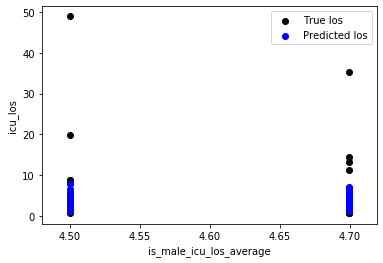

In [12]:
plt.scatter(train_X['is_male_icu_los_average'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['is_male_icu_los_average'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('is_male_icu_los_average')
plt.ylabel('icu_los')
plt.legend(['True los','Predicted los'],loc='upper right')
print('The predicted los is obvious different from true price')
plt.show()

长尾分布，不利于我们的建模预测。原因是很多模型都假设数据误差项符合正态分布，而长尾分布的数据违背了这一假设。参考博客：https://blog.csdn.net/Noob_daniel/article/details/76087829

It is clear to see the los shows a typical exponential distribution


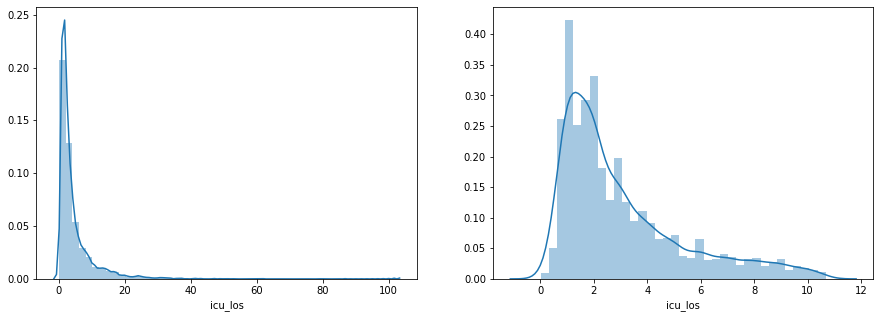

In [13]:
import seaborn as sns
print('It is clear to see the los shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

我们的数据长尾分布不是很严重，可能因为数字非常接近，2到10也只差了8，但是price最后到了15000，距离2000，差了13000了，不利于建模预测

In [ ]:
train_y_ln = np.log(train_y + 1)

In [ ]:
import seaborn as sns
print('The transformed los seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [ ]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

In [ ]:
# 这里也只是演示一下，效果好像差了些

In [ ]:
plt.scatter(train_X['is_male_icu_los_average'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['is_male_icu_los_average'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('is_male_icu_los_average')
plt.ylabel('icu_los')
plt.legend(['True los','Predicted los'],loc='upper right')
print('The predicted los is obvious different from true price')
plt.show()

In [ ]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
train = sample_feature[continuous_feature_names + ['icu_los']]

train_X = train[continuous_feature_names]
train_y = train['icu_los']
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)

### 五折交叉验证

在使用训练集对参数进行训练的时候，经常会发现人们通常会将一整个训练集分为三个部分（比如mnist手写训练集）。一般分为：训练集（train_set），评估集（valid_set），测试集（test_set）这三个部分。这其实是为了保证训练效果而特意设置的。其中测试集很好理解，其实就是完全不参与训练的数据，仅仅用来观测测试效果的数据。而训练集和评估集则牵涉到下面的知识了。

因为在实际的训练中，训练的结果对于训练集的拟合程度通常还是挺好的（初始条件敏感），但是对于训练集之外的数据的拟合程度通常就不那么令人满意了。因此我们通常并不会把所有的数据集都拿来训练，而是分出一部分来（这一部分不参加训练）对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。这种思想就称为交叉验证（Cross Validation）

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [15]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [16]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [17]:
#使用线性回归模型，对未处理标签的特征数据进行五折交叉验证（Error 0.789）
print('AVG:', np.mean(scores))

AVG: 0.7890298813898626


In [18]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [19]:
# 使用线性回归模型，对处理过标签的特征数据进行五折交叉验证（Error 3.365）
print('AVG:', np.mean(scores))

AVG: 3.365557203186264


In [20]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,3.453993,3.328082,3.436339,3.276758,3.332615


### 模拟真实业务情况
设计到时间上的处理，一般用时间在前的预测时间在后的数据。
* 例参赛题目：由于我们并不具有预知未来的能力，五折交叉验证在某些与时间相关的数据集上反而反映了不真实的情况。通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大

In [21]:
import datetime

In [22]:
sample_feature = sample_feature.reset_index(drop=True)

In [23]:
split_point = len(sample_feature) // 5 * 4

In [26]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y = np.log(train['icu_los'] + 1)
val_X = val[continuous_feature_names]
val_y = np.log(val['icu_los'] + 1)

In [27]:
model = model.fit(train_X, train_y)

In [41]:
mean_absolute_error(val_y, model.predict(val_X))

0.5172612136996853

### 绘制学习率曲线与验证曲线

In [29]:
from sklearn.model_selection import learning_curve, validation_curve

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from 'C:\\Users\\58297\\.conda\\envs\\tf2.0\\lib\\site-packages\\matplotlib\\pyplot.py'>

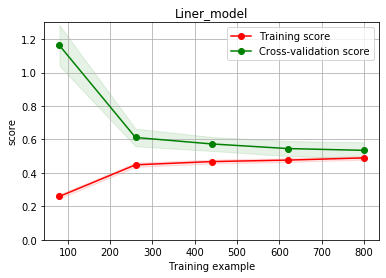

In [33]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 1.3), cv=5, n_jobs=1)  

### 多种模型对比

线性模型 & 嵌入式特征选择

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [35]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [37]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [38]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.510506,0.510500,0.566038
cv2,0.507536,0.507528,0.554517
cv3,0.506019,0.506024,0.536524
cv4,0.492129,0.492116,0.543611
cv5,0.500618,0.500609,0.541823


intercept:-5.987646433700833


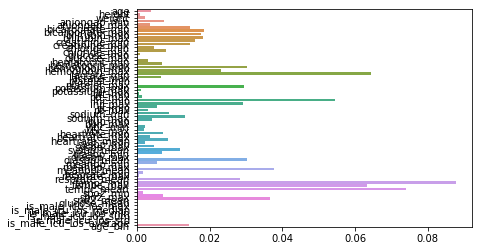

In [42]:
model = LinearRegression().fit(train_X, train_y)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。可以设想一下对于一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；但如果参数足够小，数据偏移得多一点也不会对结果造成什么影响，专业一点的说法是『抗扰动能力强』

intercept:-5.986479839877516


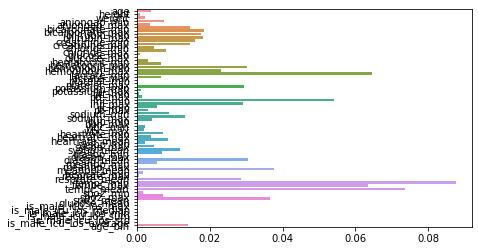

In [43]:
model = Ridge().fit(train_X, train_y)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。如下图，我们发现power与userd_time特征非常重要。

intercept:0.7668527700335115


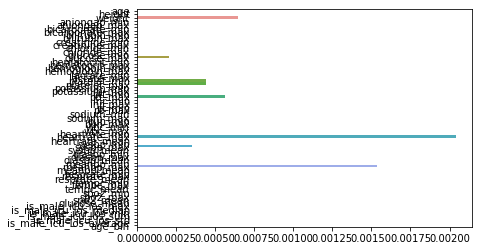

In [44]:
model = Lasso().fit(train_X, train_y)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)
# 明显减少了特征，对于数据量不大来说，降维还是很好的

### 除此之外，决策树通过信息熵或GINI指数选择分裂节点时，优先选择的分裂特征也更加重要，这同样是一种特征选择的方法。XGBoost与LightGBM模型中的model_importance指标正是基于此计算的

## 非线性模型

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [46]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

In [47]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


In [48]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.510506,0.672410,0.512911,0.507597,2.282816,0.534341,0.503936
cv2,0.507536,0.713804,0.512192,0.502496,1.229911,0.509671,0.493513
cv3,0.506019,0.709675,0.488971,0.486520,2.887075,0.506885,0.477006
cv4,0.492129,0.729656,0.517067,0.506823,1.743105,0.535120,0.502378
cv5,0.500618,0.710906,0.512530,0.493572,1.887050,0.515979,0.490197


In [49]:
# 我们预测住院天数中看起来LGBMR这些都还行，可能MLPRegressor不太理想

# 模型调参

In [50]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

### 贪心调参

In [51]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

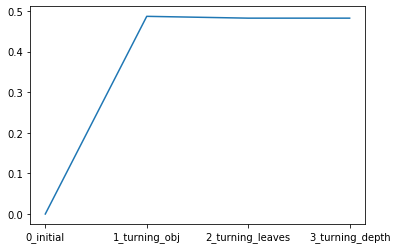

In [53]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

# 为什么是上升的，还有疑问，Xgboost集成学习类型的模型，自己接触的不多，学习了再来改改

### Grid Search 调参

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [56]:
clf.best_params_

{'max_depth': 15, 'num_leaves': 20, 'objective': 'huber'}

In [58]:
model = LGBMRegressor(objective='regression',
                          num_leaves=20,
                          max_depth=15)

In [59]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

0.49454326338853355

### 贝叶斯调参

In [61]:
from bayes_opt import BayesianOptimization

In [60]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [62]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [63]:
rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.5154   |  12.03    |  23.48    |  45.13    |  0.891    |
|  2        |  0.5151   |  44.48    |  59.15    |  82.13    |  0.469    |
|  3        |  0.5132   |  20.89    |  28.89    |  84.96    |  0.6077   |
|  4        |  0.5147   |  92.24    |  26.25    |  17.44    |  0.5646   |
|  5        |  0.513    |  27.91    |  20.23    |  86.06    |  0.2628   |
|  6        |  0.4964   |  5.252    |  97.22    |  2.338    |  0.3807   |
|  7        |  0.5161   |  97.61    |  95.0     |  95.79    |  0.5069   |
|  8        |  0.5025   |  99.29    |  2.479    |  97.03    |  0.1087   |
|  9        |  0.5107   |  3.089    |  98.82    |  99.11    |  0.691    |
|  10       |  0.5177   |  94.08    |  96.41    |  98.29    |  0.8924   |
|  11       |  0.5054   |  24.43    |  2.84     |  3.38     |  0.2197   |
|  12       |  0.5164   |  98.18    | 

In [64]:
1 - rf_bo.max['target']

0.48190825924852143

# 总结

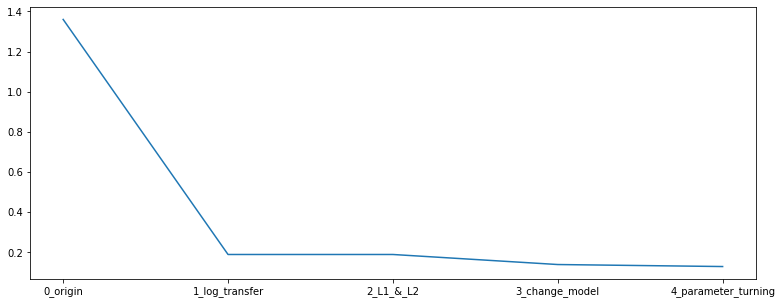

In [65]:
plt.figure(figsize=(13,5))
sns.lineplot(x=['0_origin','1_log_transfer','2_L1_&_L2','3_change_model','4_parameter_turning'], y=[1.36 ,0.19, 0.19, 0.14, 0.13])